In [46]:
# Import libraries
import gym
from envs.binomial_tree import BinomialTree, decode_action, encode_action, plot_q_values    # custom BinomialTree dynamics
from envs import plotting
import numpy as np
import pandas as pd
import math
from collections import defaultdict
import itertools

Actions denote the fraction of wealth invested in the **risky asset**. Actions are discretized with a step size of 10%, i.e.

$$
\mathcal{A}=[0, 0.1, 0.2, \dots, 0.9, 1].
$$

In [2]:
actions = np.arange(0, 1.01, step=0.1)                  #vector of actions, discrete investment decisions in 10% steps
print("Actions (Investment in risky asset):", actions)  

Actions (Investment in risky asset): [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


Now we can create an instance of the environment. We use the class BinomialTree which simulates the price movements of a risky asset according to an two-step binomial tree with up/down probabilities $p_u = 4/9$ and $p_d=5/9$ and up and down returns $r_u=1$ (i.e. 100%) and $r_d=-1/2$ (i.e. -50%) and riskfree rate $r_f=0$, hence the riskfree rate satisfies
$$r_d < r_f < r_u.$$
Furthermore, we assume an initial wealth of 100 and a **square root utility function** $U(V_T)=\sqrt(V_T)$ of terminal wealth $V_T$. The rewards are zero at all time steps before termination and equal to $R_T=\sqrt{V_T}$ at termination.

In [3]:
# Creating the environment (class BinomalTree)

# using U(V_T)=sqrt(V_T)
#Inputs: up_prob, up_ret, down_ret, r, T, dt, V_0, actions, utility
env = BinomialTree(up_prob=4/9, up_ret=1, down_ret=-0.5, r=0, T=2, dt=1, V_0=100, actions=actions, utility="sqrt")

C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


States are represented as tuples $(n_t, V_t)$, where $n_t$ denotes the n-th timestep, i.e. if we take $T=5$ and $dt=0.5$ as an example, then the state $s=(0, 100)$ denotes the intial state (i.e. $V_0=100$) and $s=(3, 150)$ denotes the state of having a wealth of 150 at time $t=0+3*dt=1.5$ (i.e. $V_{1.5}=150$).\
Lets sample some steps from the environment...

In [4]:
# Simulation of BinomialTree dynmics
print(env.reset())      # Reset the environment to state (0, 100)
print(env.step(10))     # Take the action 10 (i.e. 90% investment in risky asset) and observe the next state and reward
print(env.step(10))     # Take the action 10 (i.e. 90% investment in risky asset) and observe the next state and reward
print(env.V_t)          # Prints the current wealth

(0, 100)
((1, 50.0), 0, False, {})
((2, 100.0), 10.0, True, {})
100.0


**Epsilon-Greedy Policy**\
Source: https://www.geeksforgeeks.org/q-learning-in-python/#:~:text=Q%2DLearning%20is%20a%20basic,defined%20for%20states%20and%20actions.

In [5]:
def createEpsilonGreedyPolicy(Q, epsilon, num_actions): 
    """ 
    Creates an epsilon-greedy policy based 
    on a given Q-function and epsilon. 
       
    Returns a function that takes the state 
    as an input and returns the probabilities 
    for each action in the form of a numpy array  
    of length of the action space(set of possible actions). 
    """
    def policyFunction(state): 
   
        Action_probabilities = np.ones(num_actions, 
                dtype = float) * epsilon / num_actions 
                  
        best_action = np.argmax(Q[state]) 
        Action_probabilities[best_action] += (1.0 - epsilon) 
        return Action_probabilities 
   
    return policyFunction

**Q-Learning Algorithm** \
Source: https://www.geeksforgeeks.org/q-learning-in-python/#:~:text=Q%2DLearning%20is%20a%20basic,defined%20for%20states%20and%20actions.

In [6]:
def qLearning(env, num_episodes, discount_factor = 1, alpha = 1, epsilon = 1): 
    """ 
    Q-Learning algorithm: Off-policy TD control. 
    Finds the optimal greedy policy while improving 
    following an epsilon-greedy policy
    """
       
    # Action value function 
    # A nested dictionary that maps 
    # state -> (action -> action-value). 
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) 
    A = defaultdict(lambda: np.zeros(env.action_space.n))
   
    # Keeps track of useful statistics 
    stats = plotting.EpisodeStats( 
        episode_lengths = np.zeros(num_episodes), 
        episode_rewards = np.zeros(num_episodes))     
       
    # Create an epsilon greedy policy function 
    # appropriately for environment action space 
    policy = createEpsilonGreedyPolicy(Q, epsilon, env.action_space.n) 
       
    # For every episode
    returns=np.array([])
    terminal_wealths = np.array([])
    for ith_episode in range(num_episodes): 
           
        # Reset the environment and pick the first action 
        state = env.reset() 
           
        for t in itertools.count(): 
               
            # get probabilities of all actions from current state 
            action_probabilities = policy(state)
   
            # choose action according to  
            # the probability distribution 
            action = np.random.choice(np.arange( 
                      len(action_probabilities)), 
                       p = action_probabilities)
            A[state][action] += 1
   
            # take action and get reward, transit to next state 
            next_state, reward, done, _ = env.step(action)
   
            # Update statistics 
            stats.episode_rewards[ith_episode] += reward 
            stats.episode_lengths[ith_episode] = t
               
            # TD Update 
            best_next_action = np.argmax(Q[next_state])     
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += (1/A[state][action]) * td_delta          # Dynamic Learning Rate alpha=1/#visits of state-action pair
                                                                         # ensures convergence see Sutton & Barto eq. (2.7)
            # done is True if episode terminated    
            if done: 
                returns = np.append(returns, reward)
                terminal_wealths=np.append(terminal_wealths, env.V_t)
                break
                   
            state = next_state
        
        if ith_episode % 10000 == 0:            
            print("Episode: {}, Mean Return: {}, Mean Wealth (V_T): {}, Epsilon: {}".format(ith_episode, round(returns.mean(), 3), round(terminal_wealths.mean(), 3), epsilon))
            #print("td_delta:", td_delta)
            returns = np.array([])
            terminal_wealths=np.array([])
            
        # Epsilon-Decay    
        if (ith_episode % 10000 == 0) & (ith_episode != 0):
            epsilon *= 0.98
            policy = createEpsilonGreedyPolicy(Q, epsilon, env.action_space.n)
        #    alpha = 0.1
        
        # Alpha-Decay
        #if (ith_episode % 30000 == 0) & (ith_episode != 0):
        #    if alpha > 0.0011:
        #        alpha *= 1/10
            
       
    return Q, stats, A

Now we can start training our agent...

In [7]:
# Training of the Agent
num_episodes = 2500000                     # Training for 2.5 mio. Episodes
Q, stats, A = qLearning(env, num_episodes)

Episode: 0, Mean Return: 10.0, Mean Wealth (V_T): 100.0, Epsilon: 1
Episode: 10000, Mean Return: 10.394, Mean Wealth (V_T): 117.463, Epsilon: 1
Episode: 20000, Mean Return: 10.403, Mean Wealth (V_T): 117.579, Epsilon: 0.977
Episode: 30000, Mean Return: 10.416, Mean Wealth (V_T): 117.707, Epsilon: 0.954529
Episode: 40000, Mean Return: 10.398, Mean Wealth (V_T): 117.444, Epsilon: 0.932574833
Episode: 50000, Mean Return: 10.478, Mean Wealth (V_T): 119.55, Epsilon: 0.9111256118409999
Episode: 60000, Mean Return: 10.331, Mean Wealth (V_T): 116.268, Epsilon: 0.8901697227686569
Episode: 70000, Mean Return: 10.379, Mean Wealth (V_T): 117.431, Epsilon: 0.8696958191449777
Episode: 80000, Mean Return: 10.421, Mean Wealth (V_T): 118.361, Epsilon: 0.8496928153046432
Episode: 90000, Mean Return: 10.419, Mean Wealth (V_T): 118.62, Epsilon: 0.8301498805526364
Episode: 100000, Mean Return: 10.376, Mean Wealth (V_T): 117.764, Epsilon: 0.8110564332999257
Episode: 110000, Mean Return: 10.363, Mean Wealth 

Episode: 880000, Mean Return: 10.482, Mean Wealth (V_T): 120.284, Epsilon: 0.13207695369531214
Episode: 890000, Mean Return: 10.527, Mean Wealth (V_T): 122.342, Epsilon: 0.12903918376031995
Episode: 900000, Mean Return: 10.473, Mean Wealth (V_T): 120.511, Epsilon: 0.1260712825338326
Episode: 910000, Mean Return: 10.501, Mean Wealth (V_T): 120.892, Epsilon: 0.12317164303555445
Episode: 920000, Mean Return: 10.504, Mean Wealth (V_T): 121.776, Epsilon: 0.12033869524573669
Episode: 930000, Mean Return: 10.47, Mean Wealth (V_T): 120.247, Epsilon: 0.11757090525508475
Episode: 940000, Mean Return: 10.488, Mean Wealth (V_T): 120.657, Epsilon: 0.11486677443421779
Episode: 950000, Mean Return: 10.542, Mean Wealth (V_T): 122.004, Epsilon: 0.11222483862223077
Episode: 960000, Mean Return: 10.471, Mean Wealth (V_T): 120.146, Epsilon: 0.10964366733391946
Episode: 970000, Mean Return: 10.498, Mean Wealth (V_T): 120.041, Epsilon: 0.1071218629852393
Episode: 980000, Mean Return: 10.557, Mean Wealth (V_

Episode: 1740000, Mean Return: 10.561, Mean Wealth (V_T): 123.332, Epsilon: 0.01785498638427188
Episode: 1750000, Mean Return: 10.573, Mean Wealth (V_T): 123.794, Epsilon: 0.017444321697433627
Episode: 1760000, Mean Return: 10.547, Mean Wealth (V_T): 123.212, Epsilon: 0.017043102298392652
Episode: 1770000, Mean Return: 10.494, Mean Wealth (V_T): 121.425, Epsilon: 0.01665111094552962
Episode: 1780000, Mean Return: 10.605, Mean Wealth (V_T): 124.626, Epsilon: 0.01626813539378244
Episode: 1790000, Mean Return: 10.621, Mean Wealth (V_T): 125.007, Epsilon: 0.015893968279725442
Episode: 1800000, Mean Return: 10.569, Mean Wealth (V_T): 123.791, Epsilon: 0.015528407009291756
Episode: 1810000, Mean Return: 10.516, Mean Wealth (V_T): 122.483, Epsilon: 0.015171253648078045
Episode: 1820000, Mean Return: 10.482, Mean Wealth (V_T): 121.952, Epsilon: 0.01482231481417225
Episode: 1830000, Mean Return: 10.507, Mean Wealth (V_T): 122.032, Epsilon: 0.014481401573446288
Episode: 1840000, Mean Return: 10.

Since the returns have a high variance, we cannot really see an clear improvement in the following plots, but with the parameters specified as above we know that the agents learned the optimal investment decision of $a_t = 0.7\, \forall t$ if we achieve a mean wealth of around 124.

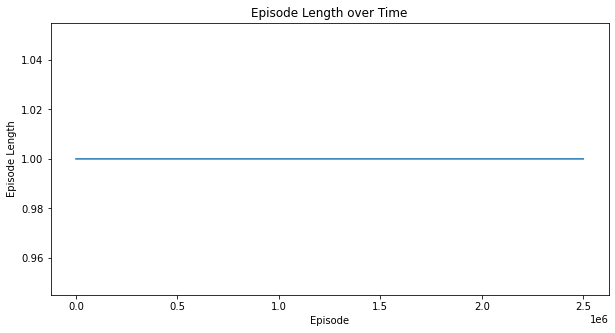

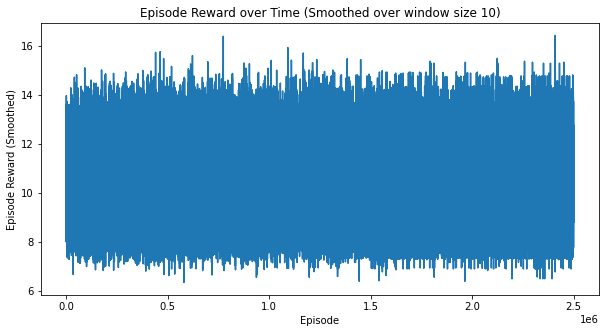

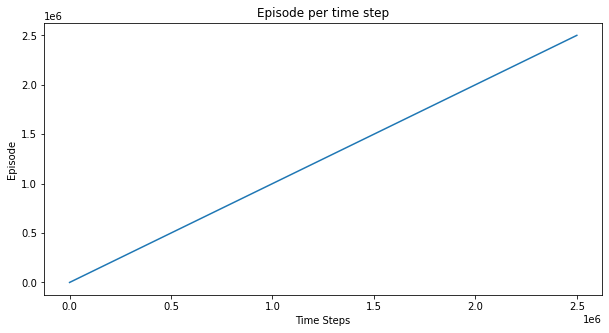

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [8]:
plotting.plot_episode_stats(stats) 

Now we can print the Q-values for each state-action pair.

In [9]:
for key in Q.keys():
    print("Key:", key)
    print("State-Action Values:", Q[key], sep="\n")
    print("Best Action (Investment in risky asset):", decode_action(np.argmax(Q[key]), actions))

Key: (0, 100)
State-Action Values:
[10.34903377 10.4376086  10.49714289 10.50789441 10.55904531 10.55901845
 10.55904397 10.55922695 10.55909035 10.55915795 10.53469319]
Best Action (Investment in risky asset): 0.7000000000000001
Key: (1, 100.0)
State-Action Values:
[10.         10.06734273 10.14020214 10.16584406 10.27922901 10.25275985
 10.13745711 10.25183208 10.25219272 10.21494634 10.25197625]
Best Action (Investment in risky asset): 0.4
Key: (2, 100.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (1, 120.0)
State-Action Values:
[10.95445115 11.05487005 11.0824374  11.16908896 11.18413626 11.2470751
 11.24779133 11.25570375 11.21679182 11.12703285 11.23021193]
Best Action (Investment in risky asset): 0.7000000000000001
Key: (2, 120.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (1, 200.0)
State-Action Values:
[14.14213562 14.26235763 14.42137451 14.35315094 14

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 161.5)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 45.49999999999999)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 90.25)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 117.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 220.00000000000003)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 42.249999999999986)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 36.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 221.00000000000003)
State-Action Values:
[0. 0. 0. 0. 0

In [10]:
# How often was each action take in each state
for key, value in A.items():
    print("State: {}, Actions: {}".format(key, value))

State: (0, 100), Actions: [  39320.   39183.   39408.   39778.  110033.  201612.  295426. 1444292.
  152664.   98533.   39751.]
State: (1, 100.0), Actions: [ 1799.  1783.  1788.  1831.  2769.  3095.  1821.  2859.  2706.  2050.
 16819.]
State: (1, 120.0), Actions: [ 811.  791.  820.  818.  833. 1364. 5075. 4419.  921.  964.  807.]
State: (1, 200.0), Actions: [ 805.  800.  886.  784. 2921.  927. 6087. 1285.  871.  819. 1406.]
State: (1, 180.0), Actions: [ 1870.  1939.  1874.  1866.  3911. 45648.  1933.  1983.  2619.  2069.
  1887.]
State: (1, 85.0), Actions: [ 1051.  1011.  1019.   990.  1037.  1097.  1052.  1240. 11723.  1034.
  1037.]
State: (1, 110.00000000000001), Actions: [ 823.  830.  763.  756. 1594. 1102. 1572. 5555. 1005.  812. 2525.]
State: (1, 80.0), Actions: [ 1913.  1956.  1951.  1989.  2574.  1974. 37194.  4809.  1904.  2012.
  2919.]
State: (1, 75.0), Actions: [ 2104.  2110.  2115.  2296.  2654.  2136.  7612. 82757.  3898.  2210.
  2142.]
State: (1, 95.0), Actions: [  989.

Now we can take a look at the Q-value surface for each state-action pair. The predicted optimal actions $argmax_a Q(s,a)$ are indicated as red dots.

In [43]:
plot_q_values(Q, actions)

TypeError: plot_q_values() takes 1 positional argument but 2 were given

We can see that the Q-values seem to be reasonable, as the surface is smooth. The predicted actions take values in the set $\{0.5, 0.6, 0.7, 0.8, 0.9, 1\}$ and most predicted actions seem to be around $0.7$. Still we can observe that even for this small example and training for 2.5m episodes the Q-Learning cannot figure out the theoretical optimal strategy, which is $a_t=0.7\,\, \forall s \in \mathcal{S}$.  

In [ ]:
# Training another Agent for only 5000 episodes
Q2, _, _ = qLearning(env, 5000)

In [29]:
plot_q_values(Q2, actions)

NameError: name 'Q2' is not defined

We can observe that after 5000 episodes the Q-value surface is still very rigid. Hence, it seems that the Q-values have not converged yet, and longer training is necessary.